In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re
from functools import partial

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
base = f'root://cernbox.cern.ch//eos/user/e/ekoenig/Ntuples/NanoHH4b/run2/mindiag_2018_0L'
f_sig = f'{base}/mc/ggHH4b_tree.root'

treekwargs = dict(
    weights=['xsecWeight/1000','genWeight','PUWeight'],
    treename='Events',
    normalization=None,
)
nanohh4b_sig = Tree(f_sig, sample='nanohh4b ggHH4b', **treekwargs)

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


In [3]:
f_sig = '/store/user/mkolosov/MultiHiggs/DiHiggs/RunII/NTuples/NTuple_UL2018_05Oct2023_withSFs/GluGluToHHTo4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8/signal_merged_fnal_withSFs.root'
# f_data = '/store/user/mkolosov/MultiHiggs/DiHiggs/RunII/NTuples/data_merged_fnal.root'

treekwargs = dict(
    weights=['genWeight','PUWeight'],
    treename='bbbbTree',
    normalization='eff_histo',
)

xsec = 31.05 * (5.824E-01)**2 / 1000

bbbb_sig = Tree(f_sig, xsec=xsec, sample='bbbb ggHH4b', color='lightgrey', **treekwargs)

100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


In [12]:
bbbb_sig.reweight(bbbb_sig.triggerScaleFactor * bbbb_sig.bTagScaleFactor_central)

In [13]:
import utils.fourbUtils.bbbbUtils as bbbbUtils
bbbbUtils.map_to_nano(bbbb_sig)

In [14]:
@cache_variable
def n_loose_btag(t):
    nL = 1*t.ak4_h1b1_btag_L + 1*t.ak4_h1b2_btag_L + 1*t.ak4_h2b1_btag_L + 1*t.ak4_h2b2_btag_L
    return ak.values_astype(nL, np.int32)

@cache_variable
def n_medium_btag(t):
    nM = 1*t.ak4_h1b1_btag_M + 1*t.ak4_h1b2_btag_M + 1*t.ak4_h2b1_btag_M + 1*t.ak4_h2b2_btag_M
    return ak.values_astype(nM, np.int32)

@cache_variable
def n_tight_btag(t):
    nT = 1*t.ak4_h1b1_btag_T + 1*t.ak4_h1b2_btag_T + 1*t.ak4_h2b1_btag_T + 1*t.ak4_h2b2_btag_T
    return ak.values_astype(nT, np.int32)

@cache_variable(bins=(0,100,30))
def h_dm(t):
    return np.sqrt( (t.dHH_H1_regmass - 125)**2 + (t.dHH_H2_regmass - 120)**2 )

@cache_variable(bins=(0,100,30))
def vr_h_dm(t):
    return np.sqrt( (t.dHH_H1_regmass - 179)**2 + (t.dHH_H2_regmass - 172)**2 )

bdt_features = [
    'ak4_h1b1_regpt', 'ak4_h1b2_regpt', 'ak4_h2b1_regpt', 'ak4_h2b2_regpt',
    'dHH_H1_regmass', 'dHH_H2_regmass', 'dHH_H1_pt', 'dHH_H2_pt', 
    'dHH_HH_mass', 'dHH_HH_pt','dHH_SumRegPtb', 'dHH_SumRegResb',
    'dHH_H1b1_H1b2_deltaR', 'dHH_H2b1_H2b2_deltaR', 'dHH_H1_H2_deltaEta','dHH_mindRbb', 
    'dHH_maxdEtabb','dHH_absCosTheta_H1_inHHcm', 'dHH_absCosTheta_H1b1_inH1cm', 'dHH_NbtagT',
]

hparams = dict(
            n_estimators=70,
            max_depth=4,
            learning_rate=0.1,
            min_samples_leaf=300,
            gb_args=dict(subsample=0.6),
            n_folds=2,
        )

bdt = ABCD(
    features=bdt_features,
    a=lambda t : (h_dm(t) <  25) & (n_medium_btag(t) == 4),
    b=lambda t : (h_dm(t) <  25) & (n_medium_btag(t) == 3),
    c=lambda t : (h_dm(t) >= 25) & (h_dm(t) < 50) & (n_medium_btag(t) == 4),
    d=lambda t : (h_dm(t) >= 25) & (h_dm(t) < 50) & (n_medium_btag(t) == 3),
    **hparams
)

100%|██████████| 2/2 [00:00<00:00,  6.78it/s]


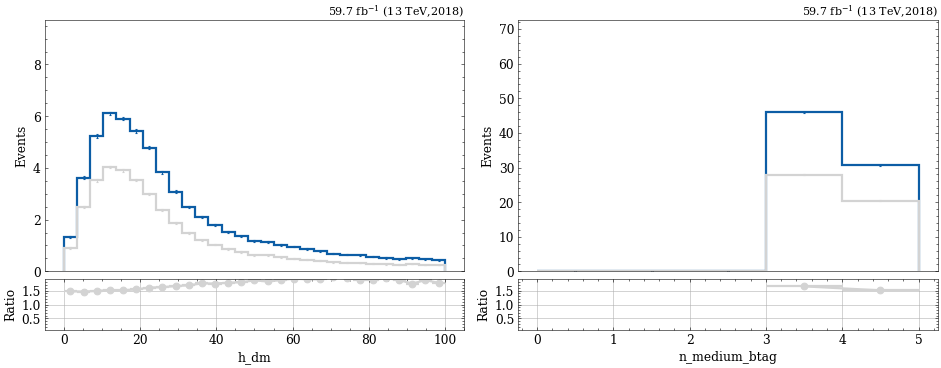

In [16]:
study.quick(
    [nanohh4b_sig, bbbb_sig],
    varlist=[h_dm, n_medium_btag],
    ratio=True,
)

In [20]:
an_yields = dict(
            a = {
                'ggHH4b' : 1189.0 + 44.8,
                'qcd-mg' : 4391.3 + 289.8,
                'ttbar-powheg' : 1379.3 + 85.5,
                'jetht': 0,
            },
            b = {
                'ggHH4b' : 788.5 + 26.4,
                'qcd-mg' : 32113.6 + 1345.0,
                'ttbar-powheg' : 14435.2 + 642.3,
                'jetht': 75628.0 + 3538.0,
            },
            c = {
                'ggHH4b' : 364.2 + 14.1,
                'qcd-mg' : 14384.3 + 582.8,
                'ttbar-powheg' : 2589.0 + 154.8,
                'jetht': 28150.0 + 1616.0,
            },
            d = {
                'ggHH4b' : 434.1 + 12.9,
                'qcd-mg' : 87038.1 + 3393.5,
                'ttbar-powheg' : 26304.3 + 1157.0,
                'jetht': 208145.0 + 9144.0,
            }
        )

In [33]:
bbbb_lepton_veto = EventFilter('lepton_Veto', filter=lambda t : (t.IsolatedMuon_Multiplicity == 0) & (t.IsolatedElectron_Multiplicity == 0), verbose=True)
bbbb_sig = bbbb_lepton_veto(bbbb_sig)

bbbb ggHH4b lepton_Veto eff: 9.85e-01


In [40]:
def get_yield(tree, region):
    label = tree.sample

    yields = an_yields[region]
    an = next( (v for k,v in yields.items() if k in label), -1)

    mask = getattr(bdt, region)(tree)
    scale = tree.scale[mask]

    if not tree.is_data:
        lumi = lumiMap[2018][0]
        scale = lumi * scale

    if tree.is_signal:
        label = f'{label} (x100)'
        scale = 100 * scale

    events = np.sum(scale)

    return (label, events, an, events/an)

In [45]:
{
    region : [ get_yield(tree, region) for tree in [nanohh4b_sig, bbbb_sig] ]
    for region in ('a','b','c','d')
}

{'a': [('nanohh4b ggHH4b (x100)',
   1940.417430617778,
   1233.8,
   1.5727163483690858),
  ('bbbb ggHH4b (x100)', 1297.8108595828844, 1233.8, 1.051881066285366)],
 'b': [('nanohh4b ggHH4b (x100)',
   1402.6205593518953,
   814.9,
   1.7212180136849862),
  ('bbbb ggHH4b (x100)', 873.4641805173422, 814.9, 1.071866708206335)],
 'c': [('nanohh4b ggHH4b (x100)',
   681.7164585534031,
   378.3,
   1.8020524941935052),
  ('bbbb ggHH4b (x100)', 415.59220222849217, 378.3, 1.0985783828403177)],
 'd': [('nanohh4b ggHH4b (x100)',
   895.8993237970781,
   447.0,
   2.0042490465259015),
  ('bbbb ggHH4b (x100)', 492.1795581086791, 447.0, 1.101072836932168)]}

In [34]:
ObjIter([nanohh4b_sig, bbbb_sig]).apply(lambda t : bdt.print_yields(t, lumi=2018))

      --- ABCD nanohh4b ggHH4b Yields ---       
Total: 4.92e+01 (64.21%)                        
SR   : 3.34e+01 (43.62%)                        
CR   : 1.58e+01 (20.59%)                        
------------------------------------------------
|           A          |           B           |
|       1.9404e+01       |       1.4026e+01        |
|        25.32%        |        18.30%         |
------------------------------------------------
|           C          |           D           |
|       6.8172e+00       |       8.9590e+00        |
|        8.90%         |        11.69%         |
------------------------------------------------
        --- ABCD bbbb ggHH4b Yields ---         
Total: 3.08e+01 (64.77%)                        
SR   : 2.17e+01 (45.67%)                        
CR   : 9.08e+00 (19.10%)                        
------------------------------------------------
|           A          |           B           |
|       1.2978e+01       |       8.7346e+00        |
|       

[None, None]

In [28]:
an_yields['a']

{'ggHH4b': 1233.8, 'qcd-mg': 4681.1, 'ttbar-powheg': 1464.8, 'jetht': 0}

In [31]:
1.9404e+01  * 100 / 1233.8

1.5727022207813262

In [35]:
1.2978e+01 * 100 / 1233.8

1.0518722645485492